In [1]:
from utils import *
import os
from grid2op.utils import ScoreL2RPN2020
from CustomGymEnv import CustomGymEnv
import numpy as np
import re

### Parameters of the agents to evaluate

In [2]:
save_path = "./saved_model/"
ENV_NAME = "l2rpn_wcci_2022_dev"
SCOREUSED = ScoreL2RPN2020
gymenv_class = CustomGymEnv
verbose = False
p = Parameters()
#p.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = True # It causes errors during training
def filter_chronics(x):
  list_chronics = ['2050-01-10_0', '2050-08-01_7'] # Names of chronics to keep
  p = re.compile(".*(" + '|'.join([c + '$' for c in list_chronics]) + ")")
  return re.match(p, x) is not None

train_args = {}
train_args["gymenv_kwargs"] = {"safe_max_rho": 0.2}

values_to_test = np.array([{"safe_max_rho": 0.5}, {"safe_max_rho": 0.7}, {"safe_max_rho": 0.9}])
var_to_test = "gymenv_kwargs"

agents_names = [[d for d in os.listdir(save_path) if os.path.isdir(save_path + d)][1]]
agents_names

['CustomGymEnv_2022-05-06_18-51']

### Evaluation

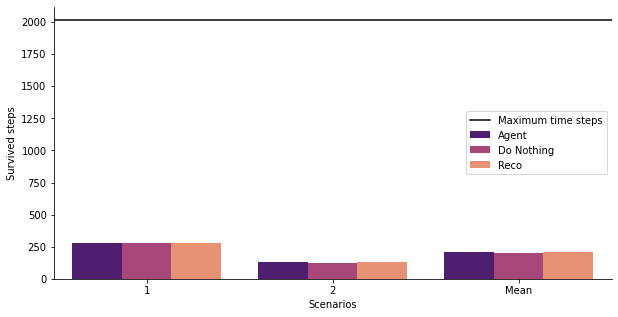

In [3]:
for i, agent_name in enumerate(agents_names):
  results = eval_agent(ENV_NAME,
            2,
            agent_name,
            save_path,
            SCOREUSED,
            gymenv_class,
            verbose,
            gymenv_kwargs=train_args["gymenv_kwargs"], #if var_to_test!="gymenv_kwargs" else values_to_test[i],
            param=p,
            filter_fun=filter_chronics)
  create_bar_plot(*results)